# HW3 — Make the 2D Photo Pop Out
**Total Points:** 100

**Due:** Thu, Oct 16 @ 11:59 PM ET

**Goal:** Backproject a single RGB image into a colored 3D point cloud.

**In this assignment, you will:**
1. Build a camera intrinsics matrix from image size and FOV.
2. Convert relative depth (Depth-Anything v2) to metric depth.
3. Backproject pixels to camera coordinates.
4. Color each 3D point from the RGB image.
5. Export a point cloud.

**What to submit:**
- The original notebook (`HW3.ipynb`)
- A PDF version of the notebook (`HW3.pdf`)
- The exported point cloud (`emory_campus_pcd.ply`)
- A screenshot of the point cloud opened in MeshLab (`emory_campus_pcd_visualized.png`)
- The point cloud built from your favorite outdoor scene photo (`favorite_scene_pcd.ply`)
- A screenshot of the point cloud built from your photo (`favorite_scene_pcd_visualized.png`)

In [41]:
import os, math
import numpy as np
import cv2
import matplotlib.pyplot as plt
import imageio

In [42]:
plt.rcParams["figure.figsize"] = (5,5)

def show(img, title=None, gray=False):
    if gray or (img.ndim==2):
        plt.imshow(img, cmap='gray')
    else:
        if img.ndim==3 and img.shape[2]==3:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        plt.imshow(img)
    if title: plt.title(title)
    plt.axis('off'); plt.show()

## Part A. Build the intrinsic matrix (20 points)
### Explanation

We’ll use the pinhole camera model with square pixels and the principal point at the image center. Since we don’t know the focal lengths \(f_x\) and \(f_y\) a priori, we will derive them from the field of view (FOV) and the image size.

**Intrinsic matrix**
$$
K =
\begin{bmatrix}
f_x & 0 & c_x\\
0 & f_y & c_y\\
0 & 0 & 1
\end{bmatrix},\quad
c_x=\frac{W}{2},\; c_y=\frac{H}{2}
$$

- `f_x`, `f_y`: focal lengths in pixels along the x and y image axes (how many pixels correspond to one unit of distance at unit depth). Assuming square pixels, `f_y = f_x`.
- `c_x`, `c_y`: the principal point in pixel coordinates (where the optical axis intersects the sensor). In this homework, we will assume the principal point at the image center.


**What is FOV?**  
The **field of view (FOV)** is the angular extent of the scene the camera sees.



### Q1-1. Derive `f_x` from horizontal FOV (`FOV_x`).
*Hint:* Use triangle. What is `tan(FOV_x / 2)`?

**Write Your Answer Here:**    
$$ f_x = \dfrac{W}{2\,\tan\!\left(\dfrac{FOV_x}{2}\right)} $$


###Q1-2. Implement `build_intrinsics(W, H, fov_deg)`
Write a function that returns the pinhole intrinsics matrix `K` given the image shape and FoV.

In [43]:
def build_intrinsics(W:int, H:int, fov_deg:float=None) -> np.ndarray:

    if fov_deg is None: fov_deg = 60.0
    K = None

    ### YOUR CODE HERE
    cx = W / 2.0
    cy = H / 2.0

    fov_rad = math.radians(fov_deg)
    fx = (W / 2.0) / math.tan(fov_rad / 2.0)
    fy = fx

    K = np.array([[fx, 0.0, cx],
                  [0.0, fy, cy],
                  [0.0, 0.0, 1.0]], dtype=np.float64)
    ### END YOUR CODE

    return K


In [44]:
def check(K, K_expected):
    np.testing.assert_allclose(K, K_expected, rtol=0, atol=1e-9)
    print("Passed!")

In [45]:
W, H, FOV = 200, 100, 90
K = build_intrinsics(W, H, FOV)
K_expected = np.array([[100.0, 0.0, 100.0],
                       [  0.0,100.0,  50.0],
                       [  0.0,  0.0,   1.0]], dtype=np.float64)
check(K, K_expected)

Passed!


## Part B. Compute Metric Depth from Relative Depth (30 points)
### Explanation

Depth-Anything v2 predicts **relative depth** that behaves like **inverse depth** (also called disparity): closer points should have larger “depth” responses than farther points. Many monocular/stereo methods model distance this way because:
- In pinhole geometry, stereo **disparity ∝ 1 / Z** (Z = metric depth).
- Inverse depth compresses very large distances and is numerically easier to learn.

We convert it to **metric depth** by assuming the model’s output is an **affine transform of inverse depth**:

- **Model:** `Z = 1 / (A + B * y)`
  - `y` = normalized relative depth in `[0, 1]`.
  - `Z` = metric depth (meters).
  - `A, B` = unknown calibration scalars.

- **Percentile calibration:**
  1) Pick two **percentiles** of `y` (e.g., `p_lo=5%` for “far-ish background”, `p_hi=95%` for “near-ish foreground”).  
  2) Assign **plausible metric depths** to those two percentiles (e.g., `ZL_target=2.5 m`, `ZH_target=0.8 m`).  
  3) Solve the two linear equations in inverse depth:
     ```
     1/ZL_target = A + B * yL
     1/ZH_target = A + B * yH
     ```
     which gives `A` and `B`.
  4) Compute metric depth per pixel:
     ```
     depth_m = 1 / (A + B * y)
     ```

Read the relative (inverse) depth map predicted by [Depth Anything V2](https://huggingface.co/spaces/depth-anything/Depth-Anything-V2).


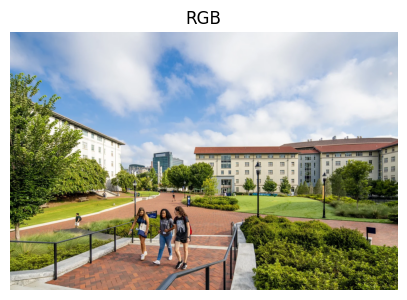

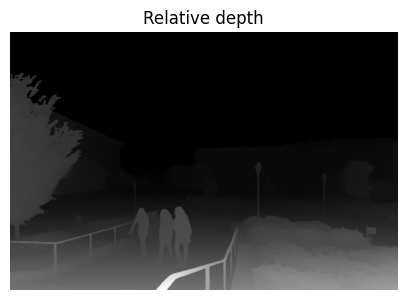

In [46]:
# Input file path
rgb_path = "emory-campus.png"
depth_raw = "emory-campus-depth-raw.png"

# --- Load RGB input ---
rgb_bgr = cv2.imread(rgb_path, cv2.IMREAD_COLOR)
assert rgb_bgr is not None, "Could not read RGB"
Hc, Wc = rgb_bgr.shape[:2]
show(rgb_bgr, "RGB")

# --- Load depth as relative (0..1) ---
depth_rel = None

r16 = cv2.imread(depth_raw, cv2.IMREAD_UNCHANGED)
if r16 is not None:
    if r16.dtype != np.uint16:
        raise ValueError("16-bit PNG must be uint16.")
    nonzero = r16[r16>0]
    denom = float(nonzero.max()) if nonzero.size else 1.0
    depth_rel = r16.astype(np.float32)/max(denom,1.0)
    show((np.clip(depth_rel,0,1)*255).astype(np.uint8), "Relative depth", gray=True)


Hd, Wd = depth_rel.shape[:2]

# Align RGB to depth resolution
if (Hd,Wd)!=(Hc,Wc):
    rgb_bgr = cv2.resize(rgb_bgr, (Wd,Hd), interpolation=cv2.INTER_LINEAR)
    Hc, Wc = rgb_bgr.shape[:2]

In [47]:
def normalize_depth(x):
    x = x.astype(np.float32)
    mn, mx = float(x.min()), float(x.max())
    return (x - mn) / (mx - mn + 1e-8)

###Q2-1. Convert inverse depth to metric depth.

Compute the metric depth.

In [48]:
# --- Depth Anything v2 calibration:  TrueDepth = 1 / (A + B * y), y in [0,1] ---
y = normalize_depth(depth_rel)  # norm_prediction

# Pick two percentiles and assign plausible metric depths (m)
p_lo, p_hi = 5.0, 95.0   # far-ish, near-ish
yL, yH = np.percentile(y, [p_lo, p_hi])
ZL_target = 2.5          # meters (far background)
ZH_target = 0.8          # meters (near foreground)

invZL, invZH = 1.0/ZL_target, 1.0/ZH_target

### YOUR CODE HERE
# Solve linear system in inverse depth: invZ = A + B*y
# Using two points (yL, invZL) and (yH, invZH)
B = (invZH - invZL) / (yH - yL + 1e-12)
A = invZL - B * yL

depth_m = 1.0 / (A + B * y + 1e-12)
### END YOUR CODE


Depth A=0.400000, B=1.932282
Valid pixels: 1462743 / 1500000


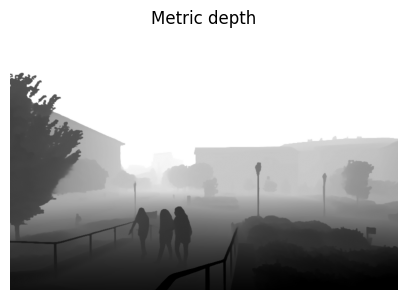

In [49]:
# Cleanup
valid = np.isfinite(depth_m) & (depth_m > 1e-6)
if valid.any():
    lo, hi = np.percentile(depth_m[valid], [1.0, 99.0])
    valid &= (depth_m>=lo) & (depth_m<=hi)

# Remove near-white background
rgb = cv2.cvtColor(rgb_bgr, cv2.COLOR_BGR2RGB)
valid &= (np.mean(rgb, axis=2) < 245)

print(f"Depth A={A:.6f}, B={B:.6f}")
print("Valid pixels:", int(valid.sum()), "/", valid.size)

# Range-normalized visualization
rng = np.ptp(depth_m[valid]) if valid.any() else 1.0
viz = (np.clip((depth_m - depth_m[valid].min()) / (rng + 1e-8), 0, 1) * 255).astype(np.uint8)
show(viz, "Metric depth", gray=True)

## Part C. 2D→3D Backprojection (30 points)
### Explanation
1) From image coordinates `u, v`, first map back to camera coordinate system by shifting the origin.
2) Then move from the image plane at depth `f` to the normalized image plane at depth `1`.
3) Finally, scale along the ray by the metric depth to recover the 3D point.

###Q3-1. Convert inverse depth to metric depth.

In [50]:
FOV_DEG = 120.0
K = build_intrinsics(Wd, Hd, fov_deg=FOV_DEG)
fx, fy, cx, cy = K[0,0], K[1,1], K[0,2], K[1,2]
print("K =\n", K)

u, v = np.meshgrid(np.arange(Wd, dtype=np.float32),
                   np.arange(Hd, dtype=np.float32))

### YOUR CODE HERE
Z = depth_m.astype(np.float32)
X = (u - cx) * Z / fx
Y = (v - cy) * Z / fy
### END YOUR CODE

pts_cam = np.stack([X[valid], Y[valid], Z[valid]], axis=1)

K =
 [[433.01270189   0.         750.        ]
 [  0.         433.01270189 500.        ]
 [  0.           0.           1.        ]]


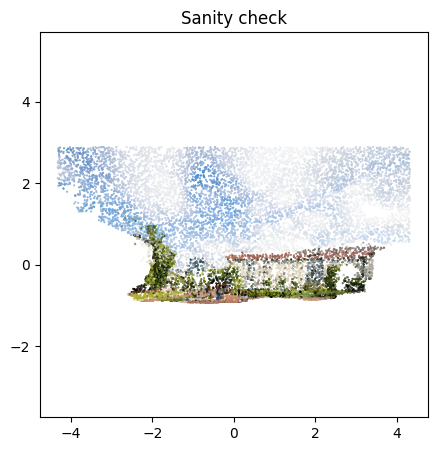

In [51]:
# Quick 2D sanity check
flat_cols = rgb.reshape(-1,3)[valid.reshape(-1)]
idx = np.random.choice(pts_cam.shape[0], min(20000, pts_cam.shape[0]), replace=False)
plt.scatter(pts_cam[idx,0], -pts_cam[idx,1], s=0.2, c=flat_cols[idx]/255.0)
plt.title("Sanity check"); plt.axis('equal'); plt.show()

Extract per-point color

In [52]:
cols = rgb.reshape(-1,3)[valid.reshape(-1)]
print("Colors:", cols.shape)

Colors: (1462743, 3)


Save point cloud to PLY

In [53]:
def write_ply(path:str, xyz:np.ndarray, rgb:np.ndarray):

    """Write ASCII PLY: x y z r g b."""
    N = xyz.shape[0]
    if rgb.dtype != np.uint8:
        rgb = np.clip(rgb, 0, 255).astype(np.uint8)

    header = "\n".join([
        "ply", "format ascii 1.0",
        f"element vertex {N}",
        "property float x", "property float y", "property float z",
        "property uchar red", "property uchar green", "property uchar blue",
        "end_header"
    ]) + "\n"

    with open(path, "w") as f:
        f.write(header)
        for (x,y,z),(r,g,b) in zip(xyz, rgb):
            f.write(f"{x:.6f} {y:.6f} {z:.6f} {int(r)} {int(g)} {int(b)}\n")
    print("Saved:", os.path.abspath(path))

In [54]:
out_ply = "emory_campus_pcd.ply"
write_ply(out_ply, pts_cam, cols)

# Auto-download
try:
    from google.colab import files
    files.download(out_ply)
except:
    pass

Saved: /Users/lauhityareddy/Repos/CS485_584/Assignments/HW3/emory_campus_pcd.ply


## Part D. Visualize the Point Cloud (10 points)
### Explanation
1) Download **MeshLab** (lightweight, open-source) from <https://www.meshlab.net/>.
2) Open `emory_campus_pcd.ply`.
3) Adjust lighting settings (Tools → Options).  
4) Hide the trackball (View → uncheck **Show Trackball**).  
5) Take a screenshot by clicking the **camera** icon. Save it as `emory_campus_pcd_visualized.png`

Adjust to a bright lighting setting as shown in the image.

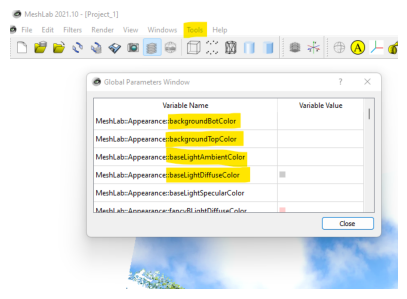

In [55]:
img_inst = cv2.imread('meshlab-adjust-lighting.png')
img_inst = cv2.cvtColor(img_inst, cv2.COLOR_BGR2RGB)
plt.imshow(img_inst)
plt.axis('off')
plt.show()

Take a screenshot.

In [56]:
pcd_img = cv2.imread('emory_campus_pcd_visualized.png')
pcd_img = cv2.cvtColor(pcd_img, cv2.COLOR_BGR2RGB)
plt.imshow(pcd_img)
plt.axis('off')
plt.show()

[ WARN:0@1420.899] global loadsave.cpp:275 findDecoder imread_('emory_campus_pcd_visualized.png'): can't open/read file: check file path/integrity


error: OpenCV(4.12.0) /Users/xperience/GHA-Actions-OpenCV/_work/opencv-python/opencv-python/opencv/modules/imgproc/src/color.cpp:199: error: (-215:Assertion failed) !_src.empty() in function 'cvtColor'


## Part E. Create a 3D Photo of Your Favorite Scene (10 points)
### Explanation
1) Open your favorite outdoor scene photo.
2) Predict the relative (inverse) depth map using [Depth Anything V2](https://huggingface.co/spaces/depth-anything/Depth-Anything-V2). Export the **16-bit raw** depth image (e.g., `favorite_scene_depth_raw.png`).
3) Build a point cloud from your photo using the predicted depth and save it as `favorite_scene_pcd.ply`.
4) Visualize the point cloud and take a screenshot saved as `favorite_scene_pcd_visualized.png`.

### Using custom.png for Part E
We use `custom.png` with a corresponding 16-bit raw depth `custom-depth-raw.png` (exported from Depth Anything V2) to build and save `favorite_scene_pcd.ply`. Run this cell after completing Parts A–C.


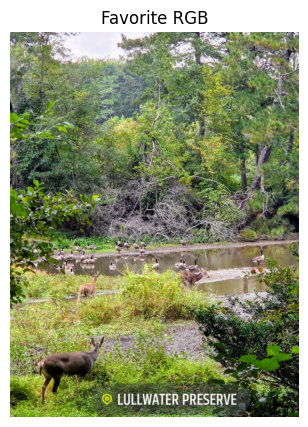

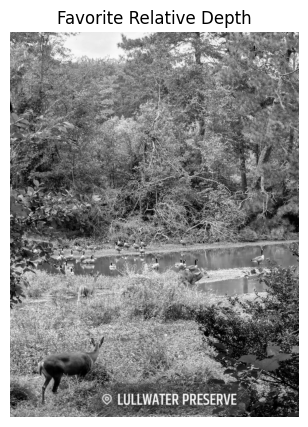

Saved: /Users/lauhityareddy/Repos/CS485_584/Assignments/HW3/favorite_scene_pcd.ply
Favorite K=
 [[480.   0. 480.]
 [  0. 480. 640.]
 [  0.   0.   1.]]
A_f=0.222222, B_f=0.944444


In [ ]:
# Part E pipeline for custom.png
# Configure paths
fav_rgb_path = "custom.png"
fav_depth_raw = "custom-depth-raw.png"  # 16-bit raw from Depth Anything V2

# Load RGB
fav_rgb_bgr = cv2.imread(fav_rgb_path, cv2.IMREAD_COLOR)
assert fav_rgb_bgr is not None, "Could not read custom.png"
Hf, Wf = fav_rgb_bgr.shape[:2]
show(fav_rgb_bgr, "Favorite RGB")

# Load depth raw (robust): prefer 16-bit; fallback to 8-bit if provided; final fallback uses grayscale luminance
fav_depth_rel = None
if os.path.exists(fav_depth_raw):
    fav_raw = cv2.imread(fav_depth_raw, cv2.IMREAD_UNCHANGED)
    if fav_raw is None:
        raise FileNotFoundError("custom-depth-raw.png exists but could not be read.")
    if fav_raw.dtype == np.uint16:
        nonzero = fav_raw[fav_raw > 0]
        scale = float(nonzero.max()) if nonzero.size else 1.0
        fav_depth_rel = fav_raw.astype(np.float32) / max(scale, 1.0)
        print("Loaded 16-bit depth raw.")
    else:
        fav_raw_f = fav_raw.astype(np.float32)
        mn, mx = float(fav_raw_f.min()), float(fav_raw_f.max())
        fav_depth_rel = (fav_raw_f - mn) / (mx - mn + 1e-8)
        print("Loaded non-16-bit depth; normalized as relative depth.")
else:
    gray = cv2.cvtColor(fav_rgb_bgr, cv2.COLOR_BGR2GRAY).astype(np.float32)
    fav_depth_rel = normalize_depth(gray)

show((np.clip(fav_depth_rel,0,1)*255).astype(np.uint8), "Favorite Relative Depth", gray=True)

# Align sizes if needed
Hdf, Wdf = fav_depth_rel.shape[:2]
if (Hdf, Wdf) != (Hf, Wf):
    fav_rgb_bgr = cv2.resize(fav_rgb_bgr, (Wdf, Hdf), interpolation=cv2.INTER_LINEAR)
    Hf, Wf = fav_rgb_bgr.shape[:2]

# Metric depth calibration (reuse Q2 approach)
yf = normalize_depth(fav_depth_rel)
p_lo, p_hi = 5.0, 95.0
yLf, yHf = np.percentile(yf, [p_lo, p_hi])
ZL_target, ZH_target = 3.0, 1.0  # typical outdoor range
invZL, invZH = 1.0/ZL_target, 1.0/ZH_target
Bf = (invZH - invZL) / (yHf - yLf + 1e-12)
Af = invZL - Bf * yLf
fav_depth_m = 1.0 / (Af + Bf * yf + 1e-12)

# Valid mask similar to Part B
fav_rgb = cv2.cvtColor(fav_rgb_bgr, cv2.COLOR_BGR2RGB)
valid_f = np.isfinite(fav_depth_m) & (fav_depth_m > 1e-6)
if valid_f.any():
    lo, hi = np.percentile(fav_depth_m[valid_f], [1.0, 99.0])
    valid_f &= (fav_depth_m>=lo) & (fav_depth_m<=hi)
valid_f &= (np.mean(fav_rgb, axis=2) < 245)

# Backproject using intrinsics from Part A
FOV_DEG_F = 90.0
Kf = build_intrinsics(Wf, Hf, fov_deg=FOV_DEG_F)
fxf, fyf, cxf, cyf = Kf[0,0], Kf[1,1], Kf[0,2], Kf[1,2]
u_f, v_f = np.meshgrid(np.arange(Wf, dtype=np.float32), np.arange(Hf, dtype=np.float32))
Zf = fav_depth_m.astype(np.float32)
Xf = (u_f - cxf) * Zf / fxf
Yf = (v_f - cyf) * Zf / fyf
pts_fav = np.stack([Xf[valid_f], Yf[valid_f], Zf[valid_f]], axis=1)
cols_fav = fav_rgb.reshape(-1,3)[valid_f.reshape(-1)]

# Save
out_fav_ply = "favorite_scene_pcd.ply"
write_ply(out_fav_ply, pts_fav, cols_fav)
print("Favorite K=\n", Kf)
print(f"A_f={Af:.6f}, B_f={Bf:.6f}")


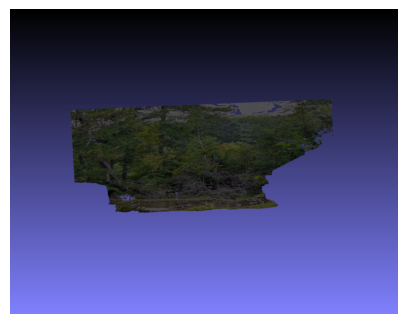

In [57]:
#show favourite scene pcd image
pcd_img = cv2.imread('/Users/lauhityareddy/Repos/CS485_584/Assignments/HW3/favourite_scene_pcd_visualized.png')
pcd_img = cv2.cvtColor(pcd_img, cv2.COLOR_BGR2RGB)
plt.imshow(pcd_img)
plt.axis('off')
plt.show()
